# CICF Week 11

This notebook covers decision trees and random forests, a classical machine learning technique.
Since the CICF course is not about data science per se, our focus is not on the math behind the method, but on the packages used to do it.
However it is uninformative to just show the steps without giving an idea of what is going on in the background, so we will cover the idea behind decision trees and in the process show the computational tools used.

We will use the Titanic dataset, which is the beginner dataset on Kaggle, a machine learning learning site.
It is a mix of categorical and numeric data.

This notebook is based on [Jeremy Howard's notebook](https://www.kaggle.com/code/jhoward/how-random-forests-really-work) of the same, which I enourage everyone who is insterested in understanding the technique to look at.

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [3]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

--2024-04-01 14:06:57--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2024-04-01 14:06:58 (5.07 MB/s) - ‘titanic.csv’ saved [60302/60302]



In [4]:
df = pd.read_csv('titanic.csv')

In [51]:
modes=df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
LogFare                   2.202765
Name: 0, dtype: object

In [7]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)
proc_data(df)

In [19]:
cats=['Sex','Embarked']
conts=['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dep='Survived'

In [9]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

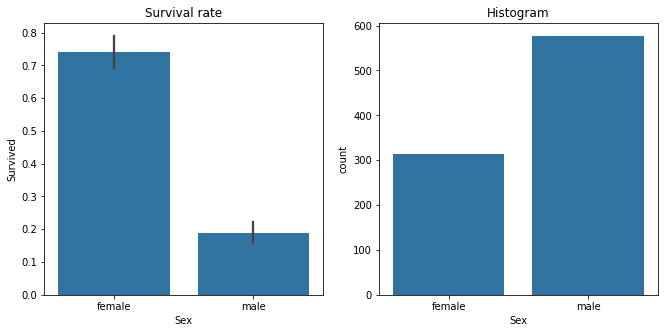

In [16]:
import seaborn as sns
fig,axs = plt.subplots(1,2,figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [17]:
from numpy import random
from sklearn.model_selection import train_test_split
random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [21]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs, df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

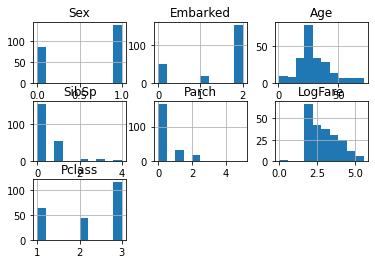

In [67]:
val_xs.hist();

In [22]:
preds = val_xs.Sex==0

In [24]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

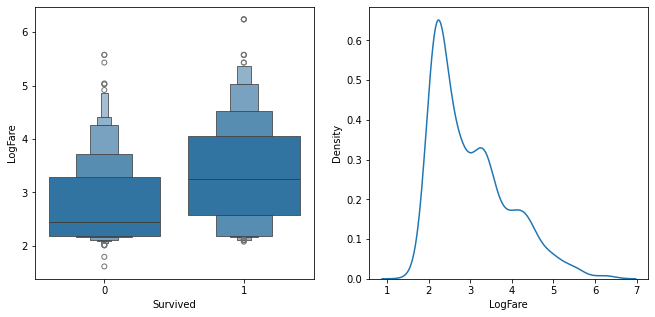

In [25]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

In [27]:
preds = val_xs.LogFare>2.7
mean_absolute_error(val_y, preds)

0.336322869955157

In [28]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)


In [30]:
score(trn_xs["Sex"], trn_y, 0.5)

0.40787530982063946

In [31]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

In [33]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col,y,o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

cols=cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

In [34]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [35]:
import graphviz
def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True, special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree }', f'Tree {{ size={size}; ratio={ratio}', s))                     

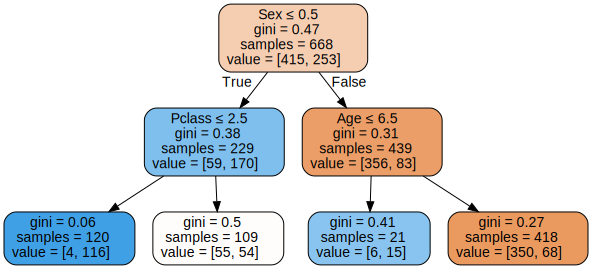

In [37]:
draw_tree(m, trn_xs, size=10)

In [38]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs =random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])


In [39]:
trees = [get_tree() for t in range(100)]

In [40]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)
mean_absolute_error(val_y, avg_probs)

0.22748878923766816

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y)
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

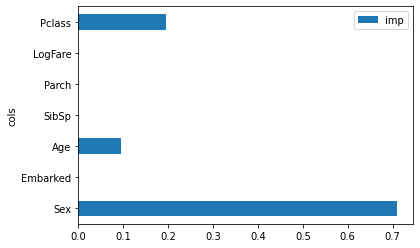

In [45]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

In [70]:
val_xs.assign(survived=val_y, prediction=rf.predict(val_xs))[:25]

,Sex,Embarked,Age,SibSp,Parch,LogFare,Pclass,survived,prediction
709,1,0,24.0,1,1,2.787834,3,1,0
439,1,2,31.0,0,0,2.442347,2,0,0
840,1,2,20.0,0,0,2.188856,3,0,0
720,0,2,6.0,0,1,3.526361,2,1,1
39,0,0,14.0,1,0,2.504848,3,1,1
290,0,2,26.0,0,0,4.380150,1,1,1
300,0,1,24.0,0,0,2.169054,3,1,1
333,1,2,16.0,2,0,2.944439,3,0,0
208,0,1,16.0,0,0,2.169054,3,1,1
136,0,2,19.0,0,2,3.306275,1,1,1
